In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

import logging

logging.basicConfig(
  format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
  datefmt="%m/%d/%Y %H:%M:%S",
  level=logging.INFO,
)

class MyResNetArgs:
   """
    Passing the hyperparameters to the model
   """
   def __init__(self, arch='resnet20' ,epochs=10, start_epoch=0, batch_size=256, lr=0.1, momentum=0.9, weight_decay=1e-4, print_freq=55,
                 evaluate=0, pretrained=0, half=0, save_dir='save_temp', save_every=10):
        self.save_every = save_every #Saves checkpoints at every specified number of epochs
        self.save_dir = save_dir #The directory used to save the trained models
        self.half = half #use half-precision(16-bit)
        self.evaluate = evaluate #evaluate model on the validation set
        self.pretrained = pretrained #evaluate the pretrained model on the validation set
        self.print_freq = print_freq #print frequency 
        self.weight_decay = weight_decay
        self.momentum = momentum 
        self.lr = lr #Learning rate
        self.batch_size = batch_size 
        self.start_epoch = start_epoch
        self.epochs = epochs
        self.arch = arch #ResNet model
 

In [2]:
       
# We define all the classes and function regarding the ResNet architecture in this code cell
__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']
 
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with diffrenet size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# A basic block as shown in Fig.3 (right) in the paper consists of two convolutional blocks, each followed by a Bach-Norm layer. 
# Every basic block is shortcuted in ResNet architecture to construct f(x)+x module. 
# Expansion for option 'A' in the paper is equal to identity with extra zero entries padded
# for increasing dimensions between layers with different feature map size. This option introduces no extra parameter. 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Stack of 3 times 2*n (n is the number of basic blocks) layers are used for making the ResNet model, 
# where each 2n layers have feature maps of size {16,32,64}, respectively. 
# The subsampling is performed by convolutions with a stride of 2.
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])


def test(net):
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    
for net_name in __all__:
    if net_name.startswith('resnet'):
        print(net_name)
        test(globals()[net_name]())
        print()

resnet20
Total number of params 269722
Total layers 20

resnet32
Total number of params 464154
Total layers 32

resnet44
Total number of params 658586
Total layers 44

resnet56
Total number of params 853018
Total layers 56

resnet110
Total number of params 1727962
Total layers 110

resnet1202
Total number of params 19421274
Total layers 1202



In [3]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = input.cuda()
        target_var = target
        if args.half:
            input_var = input_var.half()

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))




In [4]:
def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            if args.half:
                input_var = input_var.half()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()


    print('Test\t  Prec@1: {top1.avg:.3f} (Err: {error:.3f} )\n'
          .format(top1=top1,error=100-top1.avg))

    return top1.avg

def save_checkpoint(state, filename='checkpoint.th'):
    """
    Save the training model
    """
    torch.save(state, filename)


In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [6]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [7]:
args=MyResNetArgs('resnet20',pretrained=0)

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=256, shuffle=False,
        num_workers=4, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.figure(figsize=(20,10)) 

Files already downloaded and verified


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

01/03/2022 14:20:42 - WARNING - matplotlib.image -   Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


           bird            frog           horse            bird            deer            bird           plane           plane


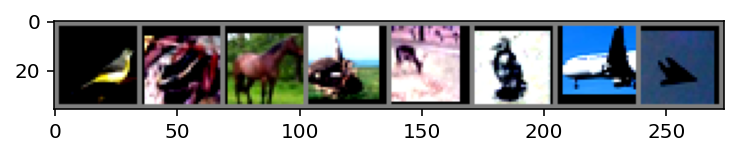

In [8]:
# show images
imshow(torchvision.utils.make_grid(images[0:8,:,:]))
# print labels
print(' '.join('%15s' % classes[labels[j]] for j in range(8)))

In [9]:
import time

logger = logging.getLogger()

def run():
    global args, best_prec1
    
    # Check the save_dir exists or not
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    model = resnet20()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_prec1 = 0

    model.cuda()


    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    if args.half:
        print('half precision is used.')
        model.half()
        criterion.half()

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                        milestones=[100, 150], last_epoch=args.start_epoch - 1)

    if args.arch in ['resnet1202']:
        # for resnet1202 original paper uses lr=0.01 for first 400 minibatches for warm-up
        # then switch back. In this setup it will correspond for first epoch.
        for param_group in optimizer.param_groups:
            param_group['lr'] = args.lr*0.1


    if args.evaluate:
        print('evalution mode')
        model.load_state_dict(torch.load(os.path.join(args.save_dir, 'model.th')))
        best_prec1 = validate(val_loader, model, criterion)
        return best_prec1

    if args.pretrained:
        print('evalution of pretrained model')
        args.save_dir='pretrained_models'
        pretrained_model= args.arch +'.th'
        model.load_state_dict(torch.load(os.path.join(args.save_dir, pretrained_model)))
        best_prec1 = validate(val_loader, model, criterion)
        return best_prec1

    logger.info('Training {} model'.format(args.arch))
    for epoch in range(args.start_epoch, args.epochs):

        # train for one epoch
        logger.info('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        if epoch > 0 and epoch % args.save_every == 0:
            save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'checkpoint.th'))
        if is_best:
            save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'model.th'))

    return best_prec1

In [10]:
run()
print('The lowest error from {} model after {} epochs is {error:.3f}'.format(args.arch,args.epochs,error=100-best_prec1))

01/03/2022 14:20:42 - INFO - root -   Training resnet20 model
01/03/2022 14:20:42 - INFO - root -   current lr 1.00000e-01


Epoch: [0][0/196]	Loss 3.9935 (3.9935)	Prec@1 7.031 (7.031)
Epoch: [0][55/196]	Loss 1.9214 (2.4277)	Prec@1 26.953 (19.120)
Epoch: [0][110/196]	Loss 1.8794 (2.1298)	Prec@1 24.219 (24.877)
Epoch: [0][165/196]	Loss 1.6542 (1.9782)	Prec@1 37.109 (28.974)


01/03/2022 14:20:47 - INFO - root -   current lr 1.00000e-01


Test	  Prec@1: 41.330 (Err: 58.670 )

Epoch: [1][0/196]	Loss 1.3977 (1.3977)	Prec@1 46.094 (46.094)
Epoch: [1][55/196]	Loss 1.4236 (1.4843)	Prec@1 48.828 (45.466)
Epoch: [1][110/196]	Loss 1.3154 (1.4294)	Prec@1 53.125 (47.639)
Epoch: [1][165/196]	Loss 1.3203 (1.3804)	Prec@1 54.688 (49.647)


01/03/2022 14:20:52 - INFO - root -   current lr 1.00000e-01


Test	  Prec@1: 43.740 (Err: 56.260 )

Epoch: [2][0/196]	Loss 1.1560 (1.1560)	Prec@1 57.031 (57.031)
Epoch: [2][55/196]	Loss 1.0797 (1.1450)	Prec@1 62.500 (58.482)
Epoch: [2][110/196]	Loss 0.9717 (1.0970)	Prec@1 66.797 (60.582)
Epoch: [2][165/196]	Loss 0.9761 (1.0683)	Prec@1 64.844 (61.582)


01/03/2022 14:20:57 - INFO - root -   current lr 1.00000e-01


Test	  Prec@1: 56.840 (Err: 43.160 )

Epoch: [3][0/196]	Loss 0.9830 (0.9830)	Prec@1 64.844 (64.844)
Epoch: [3][55/196]	Loss 0.9148 (0.9157)	Prec@1 67.969 (67.292)
Epoch: [3][110/196]	Loss 0.8638 (0.8921)	Prec@1 69.531 (68.310)
Epoch: [3][165/196]	Loss 0.7871 (0.8729)	Prec@1 72.656 (69.101)


01/03/2022 14:21:02 - INFO - root -   current lr 1.00000e-01


Test	  Prec@1: 69.730 (Err: 30.270 )

Epoch: [4][0/196]	Loss 0.7835 (0.7835)	Prec@1 74.609 (74.609)
Epoch: [4][55/196]	Loss 0.7581 (0.7658)	Prec@1 75.781 (73.382)
Epoch: [4][110/196]	Loss 0.8891 (0.7590)	Prec@1 65.625 (73.483)
Epoch: [4][165/196]	Loss 0.7405 (0.7494)	Prec@1 71.875 (73.670)


01/03/2022 14:21:07 - INFO - root -   current lr 1.00000e-01


Test	  Prec@1: 66.980 (Err: 33.020 )

Epoch: [5][0/196]	Loss 0.6857 (0.6857)	Prec@1 76.953 (76.953)
Epoch: [5][55/196]	Loss 0.5723 (0.6830)	Prec@1 79.688 (76.318)
Epoch: [5][110/196]	Loss 0.5929 (0.6735)	Prec@1 78.516 (76.524)
Epoch: [5][165/196]	Loss 0.5186 (0.6661)	Prec@1 82.031 (76.828)


01/03/2022 14:21:12 - INFO - root -   current lr 1.00000e-01


Test	  Prec@1: 71.590 (Err: 28.410 )

Epoch: [6][0/196]	Loss 0.5612 (0.5612)	Prec@1 81.250 (81.250)
Epoch: [6][55/196]	Loss 0.5831 (0.6278)	Prec@1 76.172 (78.188)
Epoch: [6][110/196]	Loss 0.6307 (0.6337)	Prec@1 80.469 (78.037)
Epoch: [6][165/196]	Loss 0.7154 (0.6234)	Prec@1 72.656 (78.240)


01/03/2022 14:21:16 - INFO - root -   current lr 1.00000e-01


Test	  Prec@1: 76.200 (Err: 23.800 )

Epoch: [7][0/196]	Loss 0.5131 (0.5131)	Prec@1 82.031 (82.031)
Epoch: [7][55/196]	Loss 0.5267 (0.5749)	Prec@1 82.031 (80.099)
Epoch: [7][110/196]	Loss 0.5000 (0.5780)	Prec@1 82.422 (80.046)
Epoch: [7][165/196]	Loss 0.4733 (0.5741)	Prec@1 84.766 (80.080)


01/03/2022 14:21:21 - INFO - root -   current lr 1.00000e-01


Test	  Prec@1: 72.640 (Err: 27.360 )

Epoch: [8][0/196]	Loss 0.5247 (0.5247)	Prec@1 79.688 (79.688)
Epoch: [8][55/196]	Loss 0.4361 (0.5373)	Prec@1 84.766 (81.138)
Epoch: [8][110/196]	Loss 0.5378 (0.5425)	Prec@1 79.297 (81.060)
Epoch: [8][165/196]	Loss 0.4873 (0.5426)	Prec@1 86.719 (81.102)


01/03/2022 14:21:26 - INFO - root -   current lr 1.00000e-01


Test	  Prec@1: 76.160 (Err: 23.840 )

Epoch: [9][0/196]	Loss 0.4030 (0.4030)	Prec@1 86.328 (86.328)
Epoch: [9][55/196]	Loss 0.4572 (0.5217)	Prec@1 86.719 (81.961)
Epoch: [9][110/196]	Loss 0.5265 (0.5184)	Prec@1 82.812 (82.049)
Epoch: [9][165/196]	Loss 0.5648 (0.5171)	Prec@1 80.078 (82.111)
Test	  Prec@1: 79.450 (Err: 20.550 )

The lowest error from resnet20 model after 10 epochs is 20.550
